# Import


In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import neuralfoil as nf
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import math

# Step 1: Take off mass

In [2]:
g = 9.81 

eng_q = 2 
con_cell_num = 6 # количество параллельных ячеек в батарее
cell_U = 4.2 # Напряжение каждой ячейки
prop_D = 22 # Диаметрр пропеллера в дюймах

LD_ratio_cruise = 14 # Отношение подъемной силы к силы лобового сопротивления
prop_efficiency = 0.75 # КПД винта
battery_specific_energy = 216 
payload_mass = 1.5 # Масса полезной нагрузки
flight_time = 90 # Время полета в минутах
flight_time_hr = flight_time / 60 # Время полета в часах
cruise_speed = 90 # Скорость полета в км/ч
cruise_speed_ms = cruise_speed / 3.6 # Скорость полета в км/ч
takeoff_mass_reserve = 1.07 # Коэффициент запаса массы для взлета
battery_mass_reserve = 1.1 # Коэффициент запаса массы аккумулятора
k = 0.3 #
n = 2.3 #
prop_fasteners = 0.015 # коэффициент добавочной массы креплений в СУ
e = 0.78 # Коэффициент Освальда


## Zero approximation of takeoff mass

In [3]:
zero_apr_mass = 5.147 * (payload_mass ** 0.849)
zero_apr_weight = zero_apr_mass * g
print(zero_apr_mass)
print(zero_apr_weight)

7.26199001085213
71.2401220064594


## First approximation of takeoff mass

In [4]:
equipment_mass = 0.46
stat_structure_mass = zero_apr_mass * 0.3
req_power = zero_apr_weight * cruise_speed / LD_ratio_cruise / prop_efficiency
one_eng_power = req_power / eng_q
eng_mass = 0.889 * (one_eng_power ** -0.288) * ((con_cell_num * cell_U) **  0.1588)
prop_mass = k * (prop_D ** n) / 1000
power_mass = eng_mass + prop_mass + prop_fasteners
battery_mass = (req_power * flight_time_hr / battery_specific_energy) * battery_mass_reserve
m0_new1 = (payload_mass + stat_structure_mass + equipment_mass + power_mass + battery_mass) * takeoff_mass_reserve

print("First approximation takeoff mass (kg):", m0_new1)
print("Power required (W):", req_power)
print("Motor mass (kg):", eng_mass)
print("Propeller mass (kg):", prop_mass)
print("Power plant mass (kg):", power_mass)
print("Battery mass (kg):", battery_mass)
print("Structure mass (kg):", stat_structure_mass)

mass_diff = (zero_apr_mass - m0_new1) / (zero_apr_mass * 100)
print("Mass difference (%):", mass_diff)

First approximation takeoff mass (kg): 10.133759849953663
Power required (W): 610.6296171982234
Motor mass (kg): 0.28565167860570095
Propeller mass (kg): 0.36702311818421196
Power plant mass (kg): 0.6676747967899129
Battery mass (kg): 4.664531798041984
Structure mass (kg): 2.1785970032556388
Mass difference (%): -0.003954521880104536


## Second approximation of takeoff mass

In [5]:
zero_apr_mass = m0_new1
req_power = zero_apr_weight * cruise_speed / LD_ratio_cruise / prop_efficiency
one_eng_power = req_power / eng_q
eng_mass = 0.889 * (one_eng_power ** -0.288) * ((con_cell_num * cell_U) **  0.1588)
prop_mass = k * (prop_D ** n) / 1000
power_mass = eng_mass + prop_mass + prop_fasteners
battery_mass = (req_power * flight_time_hr / battery_specific_energy) * battery_mass_reserve
stat_structure_mass = zero_apr_mass * 0.3
m0_new2 = (payload_mass + stat_structure_mass + equipment_mass + power_mass + battery_mass) * takeoff_mass_reserve

print("\nSecond approximation takeoff mass (kg):", m0_new2)
print("Power required (W):", req_power)
print("Motor mass (kg):", eng_mass)
print("Propeller mass (kg):", prop_mass)
print("Power plant mass (kg):", power_mass)
print("Battery mass (kg):", battery_mass)
print("Structure mass (kg):", stat_structure_mass)

mass_diff = (zero_apr_mass - m0_new1) / (zero_apr_mass * 100)
print("Mass difference (%):", mass_diff)


Second approximation takeoff mass (kg): 11.055597968305257
Power required (W): 610.6296171982234
Motor mass (kg): 0.28565167860570095
Propeller mass (kg): 0.36702311818421196
Power plant mass (kg): 0.6676747967899129
Battery mass (kg): 4.664531798041984
Structure mass (kg): 3.0401279549860987
Mass difference (%): 0.0


# Step 2: Определение параметров завязки
## Input value 1

In [6]:
stall_speed = 55 # скорость сваливания (км/ч)
air_density = 1.225 # плотность воздуха на взлете
CLmax = 1.4 # коэффициент подъемной силы крыла максимальный (по статистике)
CLmin = -0.8 # коэффициент подъемной силы крыла минимальный (по поляре профиля)
CL = 5.25 # производная CL (по поляре профиле)
WP = 0.1 # энерговооруженность (по прототипу)



## Calculation 1

In [7]:
stall_speed_ms = stall_speed / 3.6 # stall speed (m/s)
dynamic_pressuare = 0.5 * air_density * stall_speed_ms ** 2 # Dynamic pressuare on stall 
WS = CLmax * dynamic_pressuare # Wing loading on stall

print("Dynamic pressuare on stall:", dynamic_pressuare)
print("Wing loading on stall:", WS)

Dynamic pressuare on stall: 142.9639274691358
Wing loading on stall: 200.1494984567901


## Calculation 2

In [8]:
take_off_weight = m0_new2 * g
S_wing = WS / take_off_weight

print("Wing area (S):", S_wing)

Wing area (S): 1.8454541572116245


## Сalculation of battery parameters

In [9]:
series_cells_n = 6
parallel_cells_n = 4 
battery_weight = battery_mass * g
cell_U_min = 3
cell_U_max = 4.2
cell_capacity_nom_A = 4.2 
cell_capacity_nom_W = 15.5
max_current_cell = 45
cell_mass = 0.07
battery_mass_coef = 1.12

screws_n = 2
blades_n = 2
Kp = 0.0995

cell_total = series_cells_n * parallel_cells_n
pack_cell_U_min = series_cells_n * cell_U_min
pack_cell_U_max = series_cells_n * cell_U_max
pack_cell_U = series_cells_n * cell_U
pack_cell_capacity_nom_A = parallel_cells_n * cell_capacity_nom_A
pack_cell_capacity_nom_W = parallel_cells_n * cell_capacity_nom_W
pack_max_current_cell = parallel_cells_n * max_current_cell
pack_cell_mass = cell_total * cell_mass * battery_mass_coef
battery_pack_q = 1
total_battery_mass = pack_cell_mass * battery_pack_q
total_battery_capacity = battery_pack_q * pack_cell_capacity_nom_A

max_cell_q = battery_weight / battery_mass_coef / cell_mass

print("Емкость АБ:", pack_cell_capacity_nom_A, "А*ч")
print("Масса АБ:", total_battery_mass)
print("Емкость всех АБ при параллельном подключении:", total_battery_capacity, "А*ч")

Емкость АБ: 16.8 А*ч
Масса АБ: 1.8816000000000004
Емкость всех АБ при параллельном подключении: 16.8 А*ч


## Input value 3

In [10]:
Re_cruise = 511979
SwetS = 2 # Согласно таблице из источников
fric_coef = 0.74/(Re_cruise**0.2)
AR = 8 # Удлинение крыла
air_density_cruise = 1.1117
dynamic_viscosity_cruise = 0.00001787
prop_efficiency_cruise = 0.75
battery_depth = 0.3

## Calculation 3

In [11]:
Cd0 = SwetS * fric_coef
K = 0.3183 / AR / 0.78
wing_loading = WS * 1
dynamic_pressuare_cruise = 0.5 * air_density_cruise * (cruise_speed_ms ** 2)
# aerodynamic_quality = 1 / ((dynamic_pressuare_cruise*Cd0 / wing_loading) * (wing_loading * K / dynamic_pressuare_cruise))
CL_opt = np.sqrt(Cd0 / K)
CD_opt = Cd0 + K * CL_opt**2
aerodynamic_quality = CL_opt / CD_opt

eng_efficiency = prop_efficiency * 0.95
MbatM0 = total_battery_mass / m0_new2
payload_weight = payload_mass * g

print(Cd0)
print("Cruise wing loading:", wing_loading, "H/m2")
print("Cruise dynamic pressuare:", dynamic_pressuare_cruise, "H/m2")
print("Aerodynamic quality L/D:", aerodynamic_quality)
print("Отношение массы батареи к массе всего БЛА в течении заданного времени:", MbatM0)

0.1067606688226137
Cruise wing loading: 200.1494984567901 H/m2
Cruise dynamic pressuare: 347.40625 H/m2
Aerodynamic quality L/D: 6.77545299895771
Отношение массы батареи к массе всего БЛА в течении заданного времени: 0.17019432195293874


## Input value 4

In [12]:
taper_ratio = 0.57
# fuselage_lenght = 
# fuselage_width =

## Calculation 4

In [13]:
wingspan = np.sqrt(AR * S_wing)
root_chord_lenght = (2 * S_wing) / (wingspan * (1 + taper_ratio))
tip_chord_lenght = taper_ratio * root_chord_lenght
# tip_chord_lenght = wingspan * root_chord_lenght
MAC = (2/3) * root_chord_lenght * (1 + taper_ratio + taper_ratio ** 2) / (1 + taper_ratio)

print(f"Wingspan: {wingspan:.3f} m")
print(f"Lenght of middle aerodynamic chord: {MAC:.3f} m")

Wingspan: 3.842 m
Lenght of middle aerodynamic chord: 0.492 m


# Step 3: Constant analysis

C:\Users\kyco4\AppData\Local\Temp\ipykernel_9816\2205464082.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


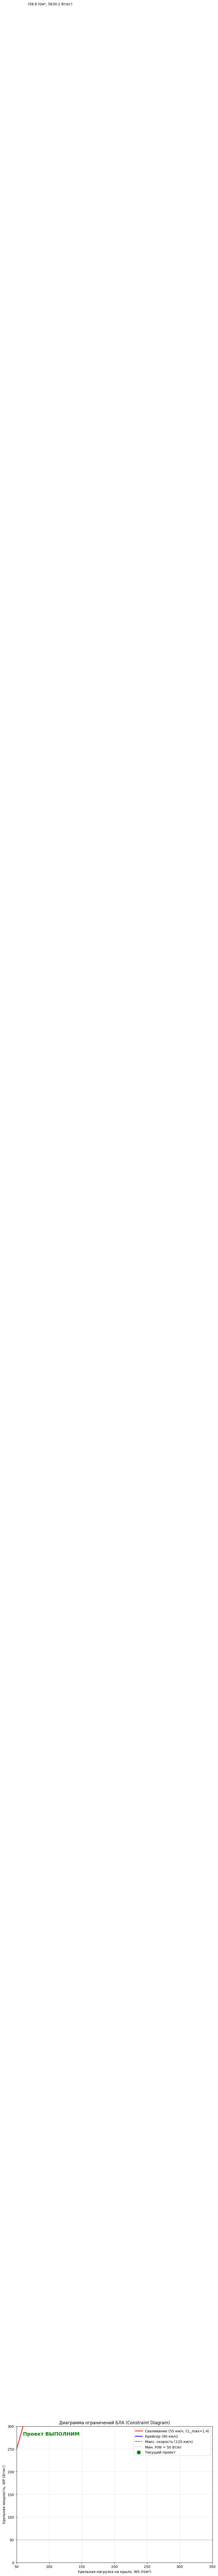

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# === ТВОИ ДАННЫЕ (из предыдущих расчётов) ===
m0 = m0_new2                    # 11.055 кг
W = m0 * g                      # Взлётный вес, Н
S = S_wing                      # Площадь крыла, м²
WS_current = W / S               # Текущая удельная нагрузка, Н/м²

P_req = req_power               # Требуемая мощность, Вт
WP_current = P_req / W           # Удельная мощность, Вт/кг

V_stall_kmh = stall_speed       # 55 км/ч
CL_max = 1.4
rho0 = 1.225                    # Плотность на уровне моря

V_cruise_ms = cruise_speed_ms   # 90 км/ч → м/с
LD_max = aerodynamic_quality    # 183.6 (очень высоко — проверь!)
CD0 = SwetS * fric_coef
K = 1 / (np.pi * AR * e)        # Индуктивное сопротивление

# === Построение диаграммы ограничений ===

# 1. Ограничение по сваливанию
def wp_stall(ws):
    V_stall = V_stall_kmh / 3.6
    return (1 / CL_max) * (2 * ws / (rho0 * V_stall**2))

# 2. Ограничение по крейсерской скорости
def wp_cruise(ws):
    q = 0.5 * air_density_cruise * V_cruise_ms**2
    CD = CD0 + K * (ws / q)**2
    return (V_cruise_ms * ws * CD) / (LD_max * ws)  # Упрощённо: P = D * V

# Более точная формула:
def wp_cruise_precise(ws):
    q = 0.5 * air_density_cruise * V_cruise_ms**2
    CL = ws / q
    CD = CD0 + K * CL**2
    return V_cruise_ms * CD / LD_max  # Вт/Н = 1/(L/D), но умножаем на V

# 3. Ограничение по максимальной скорости (например, 120 км/ч)
V_max_kmh = 120
V_max_ms = V_max_kmh / 3.6
def wp_max_speed(ws):
    q_max = 0.5 * air_density_cruise * V_max_ms**2
    CL_max_speed = ws / q_max
    CD_max = CD0 + K * CL_max_speed**2
    LD_max_speed = CL_max_speed / CD_max
    return V_max_ms / LD_max_speed

# 4. Ограничение по энерговооружённости (минимальная)
WP_min = 50  # Вт/кг — примерный минимум для устойчивого полёта

# === Диапазон для графика ===
ws_range = np.linspace(50, 350, 400)  # Н/м²

# === Построение ===
plt.figure(figsize=(10, 7))

# Линии ограничений
plt.plot(ws_range, [wp_stall(ws) * 1000 for ws in ws_range], 
         label='Сваливание (55 км/ч, CL_max=1.4)', color='red', linewidth=2)
plt.plot(ws_range, [wp_cruise_precise(ws) * 1000 for ws in ws_range], 
         label='Крейсер (90 км/ч)', color='blue', linewidth=2)
plt.plot(ws_range, [wp_max_speed(ws) * 1000 for ws in ws_range], 
         label='Макс. скорость (120 км/ч)', color='purple', linestyle='--')

# Минимальная энерговооружённость
plt.axhline(y=WP_min, color='gray', linestyle=':', label=f'Мин. P/W = {WP_min} Вт/кг')

# Текущий проект
plt.scatter(WS_current, WP_current * 1000, color='green', s=100, zorder=5, label='Текущий проект')
plt.text(WS_current + 5, WP_current * 1000, f'  ({WS_current:.1f} Н/м², {WP_current*1000:.1f} Вт/кг)', 
         fontsize=10, verticalalignment='center')

# Оформление
plt.xlabel('Удельная нагрузка на крыло, WS (Н/м²)')
plt.ylabel('Удельная мощность, WP (Вт/кг)')
plt.title('Диаграмма ограничений БЛА (Constraint Diagram)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(50, 350)
plt.ylim(0, 300)

# Добавим аннотацию
feasible = (WP_current * 1000 > wp_stall(WS_current) * 1000 and 
            WP_current * 1000 > wp_cruise_precise(WS_current) * 1000)
plt.text(60, 280, f"Проект {'ВЫПОЛНИМ' if feasible else 'НЕВЫПОЛНИМ'}", 
         color='green' if feasible else 'red', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()